# Ontario Inpatient Discharges: Counterfactual Analysis Without COVID-19

This notebook examines long-term inpatient discharge trends in Ontario and reconstructs what discharge volumes would have looked like from 1995 to 2024 if the COVID-19 pandemic had not occurred. The objective is to quantify the scale of disruption caused by the pandemic and to provide evidence that can support healthcare capacity planning and policy discussion.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Load cleaned dataset
df = pd.read_csv("/content/canada_hospital_inpatient_clean_1995_2024.csv")

In [14]:
# Ontario only
ontario = df[df["Province_Territory"] == "Ontario"]

ontario.head()

,Fiscal_Year,Province_Territory,Age_Group,Sex,Number_of_Discharges,Total_Length_of_Stay_Days,Average_Length_of_Stay_Days
300,2023–2024,Ontario,00–04,All,44641.0,223893.0,5.015412
301,2023–2024,Ontario,00–04,Female,19363.0,98408.0,5.082270
302,2023–2024,Ontario,00–04,Male,25273.0,125468.0,4.964508
303,2023–2024,Ontario,05–09,All,14253.0,46338.0,3.251105
304,2023–2024,Ontario,05–09,Female,6303.0,21368.0,3.390132


The analysis uses annual inpatient discharge data for Ontario, aggregated by fiscal year. Aggregation at the yearly level aligns with how inpatient capacity and planning decisions are typically made in Canada and allows long-term trends to be examined without short-term noise.


In [15]:
ontario_yearly = (
    ontario.groupby("Fiscal_Year", as_index=False)["Number_of_Discharges"]
    .sum()
)

ontario_yearly = ontario_yearly.reset_index(drop=True)
ontario_yearly["Year_Index"] = range(len(ontario_yearly))


In [16]:
ontario_yearly.columns


Index(['Fiscal_Year', 'Number_of_Discharges', 'Year_Index'], dtype='object')

In [17]:
covid_years = [
    "2019–2020",
    "2020–2021",
    "2021–2022",
    "2022–2023"
]


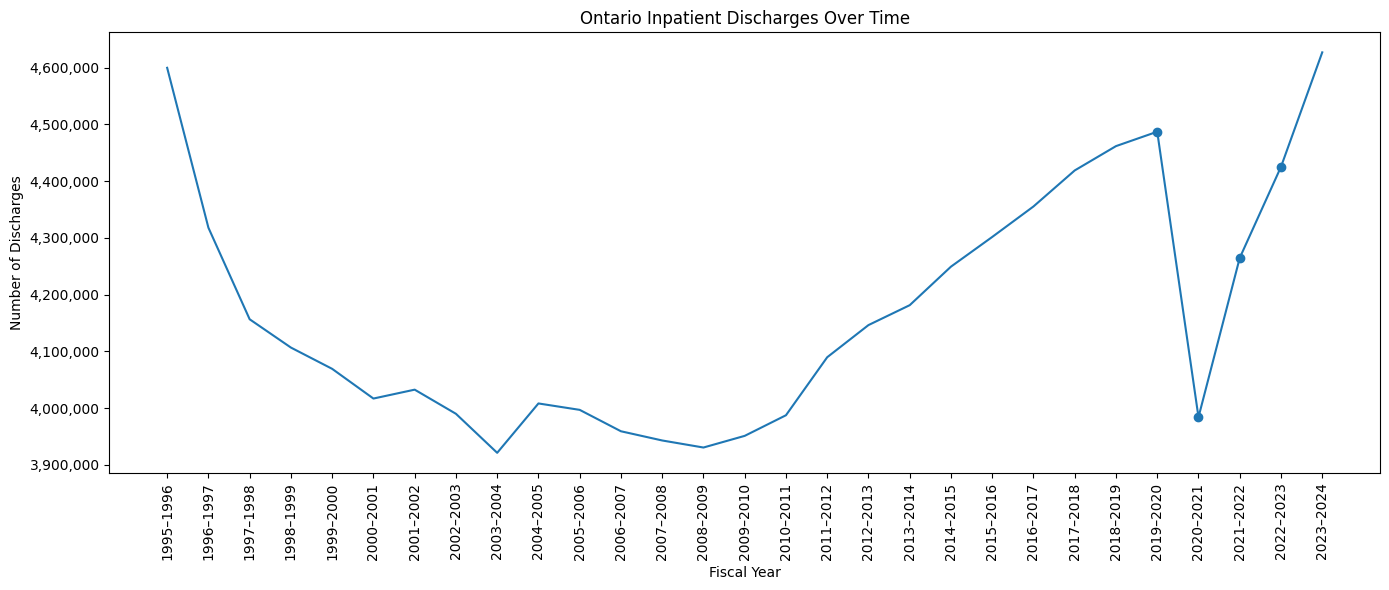

In [18]:
ontario_yearly["Period"] = "Baseline"
ontario_yearly.loc[
    ontario_yearly["Fiscal_Year"].isin(covid_years),
    "Period"
] = "COVID"

covid_mask = ontario_yearly["Period"] == "COVID"
plt.figure(figsize=(14,6))
plt.plot(
    ontario_yearly["Fiscal_Year"],
    ontario_yearly["Number_of_Discharges"],
    label="Ontario"
)
plt.scatter(
    ontario_yearly.loc[covid_mask, "Fiscal_Year"],
    ontario_yearly.loc[covid_mask,
                       "Number_of_Discharges"], )
plt.title("Ontario Inpatient Discharges Over Time")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.tight_layout()
plt.show()

The observed data show a long-term decline in inpatient discharges during the late 1990s and early 2000s, followed by a steady increase from around 2010. A sharp drop is visible during the COVID-19 period, reflecting widespread service disruption, delayed procedures, and capacity constraints. Although discharge volumes recover in later years, the pattern suggests a significant deviation from the pre-pandemic trajectory.


In [19]:
counterfactual_years = [
    "2019–2020",
    "2020–2021",
    "2021–2022",
    "2022–2023",
    "2023–2024"
]


In [20]:
train_data = ontario_yearly[
    ~ontario_yearly["Fiscal_Year"].isin(counterfactual_years)
].copy()

train_series = train_data["Number_of_Discharges"].values


In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    train_series,
    trend="add",
    seasonal=None
).fit()


In [22]:
model.forecast(len(counterfactual_years))

array([4509635.13596032, 4557594.27165324, 4605553.40734616,
       4653512.54303909, 4701471.67873201])

Reconstruct the COVID years (counterfactual)

In [23]:
counterfactual_values = model.forecast(len(counterfactual_years))

last_precovid_idx = train_data["Year_Index"].max()

counterfactual_df = pd.DataFrame({
    "Fiscal_Year": counterfactual_years,
    "Discharges_No_COVID": counterfactual_values,
    "Year_Index": range(
        last_precovid_idx + 1,
        last_precovid_idx + 1 + len(counterfactual_years)
    )
})

In [24]:
counterfactual_series = ontario_yearly.copy()

for _, row in counterfactual_df.iterrows():
    mask = counterfactual_series["Fiscal_Year"] == row["Fiscal_Year"]
    counterfactual_series.loc[mask, "Number_of_Discharges"] = row["Discharges_No_COVID"]


To assess the impact of COVID-19, a counterfactual approach is used. An exponential smoothing model is trained on pre-pandemic data only, capturing how inpatient discharges evolved under normal operating conditions. This model is then used to estimate what discharge volumes would have been during the pandemic and recovery years if the pre-COVID trend had continued uninterrupted.


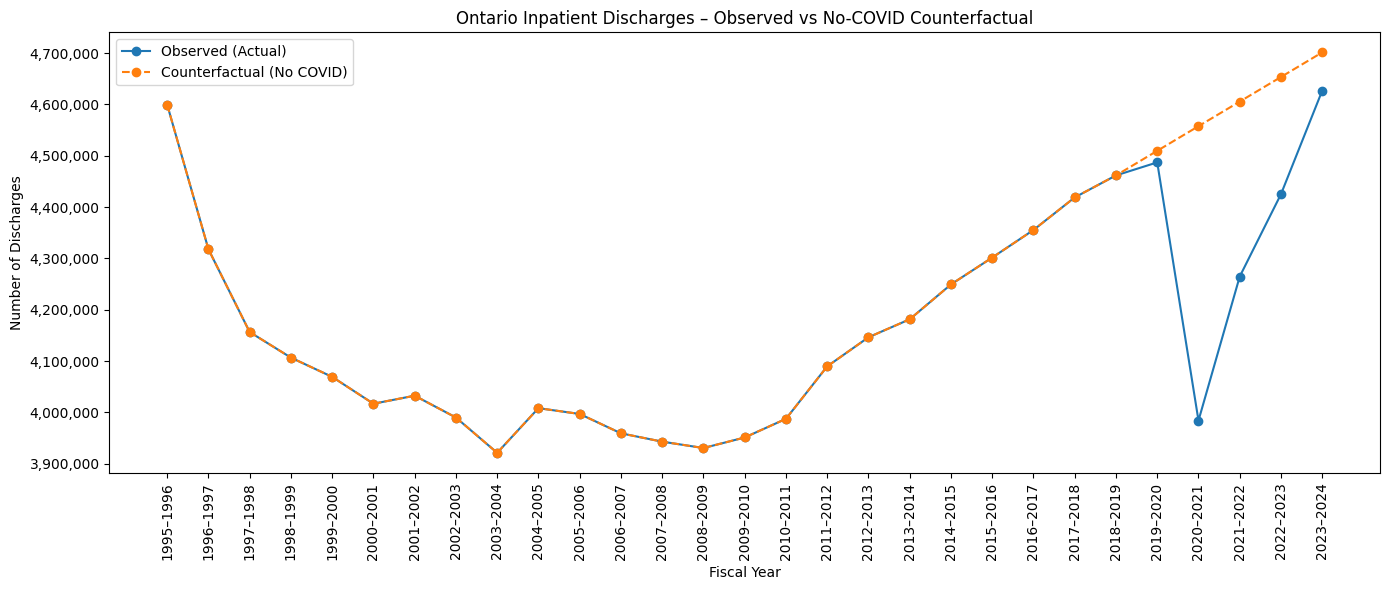

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(14,6))

plt.plot(
    ontario_yearly["Year_Index"],
    ontario_yearly["Number_of_Discharges"],
    marker="o",
    label="Observed (Actual)",
    color="tab:blue"
)

plt.plot(
    counterfactual_series["Year_Index"],
    counterfactual_series["Number_of_Discharges"],
    linestyle="--",
    marker="o",
    label="Counterfactual (No COVID)",
    color="tab:orange"
)

tick_idx = ontario_yearly["Year_Index"][::1]
tick_labels = ontario_yearly["Fiscal_Year"][::1]
plt.xticks(ticks=tick_idx, labels=tick_labels, rotation=90)

plt.title("Ontario Inpatient Discharges – Observed vs No-COVID Counterfactual")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.legend()
plt.tight_layout()
plt.show()


This figure compares observed inpatient discharges with a counterfactual scenario that removes the effects of COVID-19. Prior to 2019, both series follow the same path, as the counterfactual uses observed values. From 2019 onward, the observed series falls well below the counterfactual baseline, highlighting the scale of disruption caused by the pandemic. The sustained gap indicates that reduced inpatient activity reflects deferred care and system constraints rather than a true reduction in healthcare need.


Quantify the COVID gap

In [26]:
impact_df = counterfactual_series.merge(
    ontario_yearly[["Fiscal_Year", "Number_of_Discharges"]],
    on="Fiscal_Year",
    suffixes=("_No_COVID", "_Observed")
)


In [27]:
impact_df["COVID_Gap"] = (
    impact_df["Number_of_Discharges_No_COVID"]
    - impact_df["Number_of_Discharges_Observed"]
)

In [28]:
covid_period = impact_df[
    impact_df["Fiscal_Year"].isin(counterfactual_years)
]

total_gap = covid_period["COVID_Gap"].sum()
average_gap = covid_period["COVID_Gap"].mean()

total_gap, average_gap


(np.float64(1239945.0367308194), np.float64(247989.00734616388))

Quantifying the difference between observed and counterfactual discharges provides a clearer measure of the pandemic’s impact. The cumulative shortfall represents inpatient episodes that would have been expected under normal conditions but did not occur. This unmet activity is likely to translate into backlog pressure, increased wait times, and ongoing strain on hospital capacity.


In [29]:
covid_period[[
    "Fiscal_Year",
    "Number_of_Discharges_Observed",
    "Number_of_Discharges_No_COVID",
    "COVID_Gap"
]]


,Fiscal_Year,Number_of_Discharges_Observed,Number_of_Discharges_No_COVID,COVID_Gap
24,2019–2020,4487076.0,4.509635e+06,22559.135960
25,2020–2021,3983954.0,4.557594e+06,573640.271653
26,2021–2022,4264656.0,4.605553e+06,340897.407346
27,2022–2023,4425202.0,4.653513e+06,228310.543039
28,2023–2024,4626934.0,4.701472e+06,74537.678732


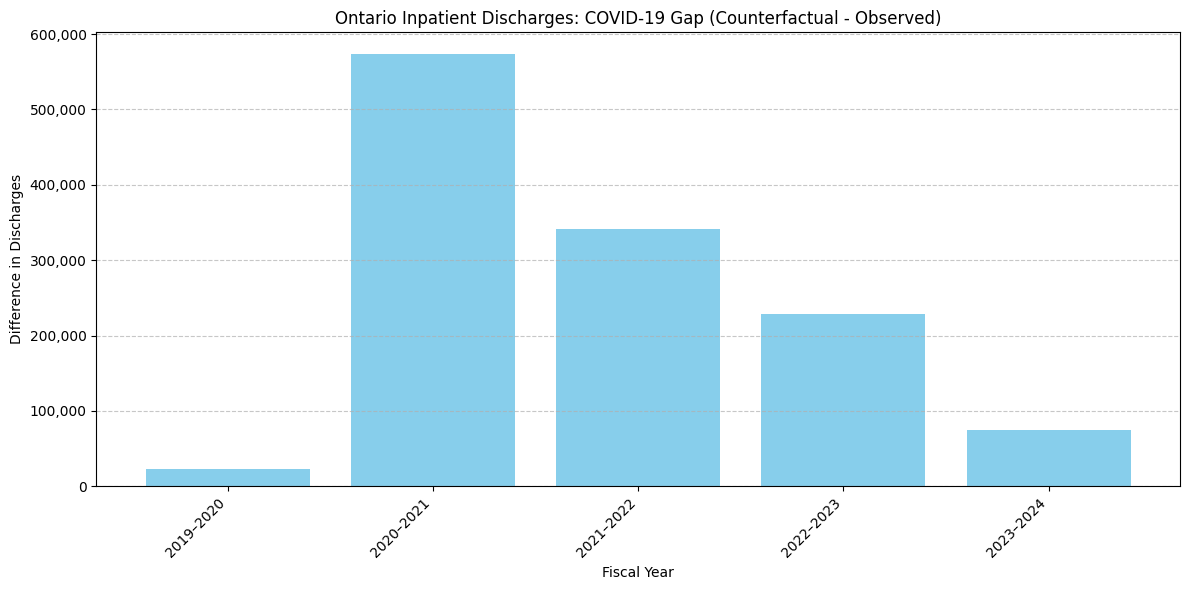

The chart illustrates the 'COVID Gap', which is the difference between the projected number of discharges if COVID-19 had not occurred (Counterfactual) and the actual observed discharges during the pandemic years.
A positive gap indicates that observed discharges were lower than what would have been expected based on pre-pandemic trends, representing potential unmet demand or delayed care.


In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Filter impact_df for the counterfactual years to show the gap
gap_df = impact_df[impact_df["Fiscal_Year"].isin(counterfactual_years)].copy()

plt.figure(figsize=(12, 6))
plt.bar(
    gap_df["Fiscal_Year"],
    gap_df["COVID_Gap"],
    color='skyblue'
)

plt.title("Ontario Inpatient Discharges: COVID-19 Gap (Counterfactual - Observed)")
plt.xlabel("Fiscal Year")
plt.ylabel("Difference in Discharges")
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("The chart illustrates the 'COVID Gap', which is the difference between the projected number of discharges if COVID-19 had not occurred (Counterfactual) and the actual observed discharges during the pandemic years.")
print("A positive gap indicates that observed discharges were lower than what would have been expected based on pre-pandemic trends, representing potential unmet demand or delayed care.")

This chart quantifies the gap between observed inpatient discharges and the no-COVID counterfactual baseline during the pandemic and recovery period. The largest shortfall occurs in 2020–2021, reflecting the peak impact of widespread service cancellations, emergency operating protocols, and reduced hospital capacity. This indicates that a substantial volume of inpatient care was deferred rather than eliminated.

Although the gap narrows in subsequent years, it remains positive through 2023–2024. This shows that the recovery did not immediately return inpatient activity to its expected baseline. Instead, hospitals appear to have faced ongoing constraints, backlog pressures, and system adjustments that limited the pace of catch-up.

The declining gap over time suggests gradual system recovery, but the persistence of unmet discharges highlights that the effects of COVID-19 extended beyond the initial crisis period. These results support the view that the pandemic caused a multi-year disruption to inpatient care delivery, with implications for backlog management and future capacity planning.

confidence bands

In [31]:
import numpy as np

residuals = model.resid
sigma = np.std(residuals)


In [32]:
counterfactual_df["Lower_Bound"] = (
    counterfactual_df["Discharges_No_COVID"] - 1.96 * sigma
)
counterfactual_df["Upper_Bound"] = (
    counterfactual_df["Discharges_No_COVID"] + 1.96 * sigma
)


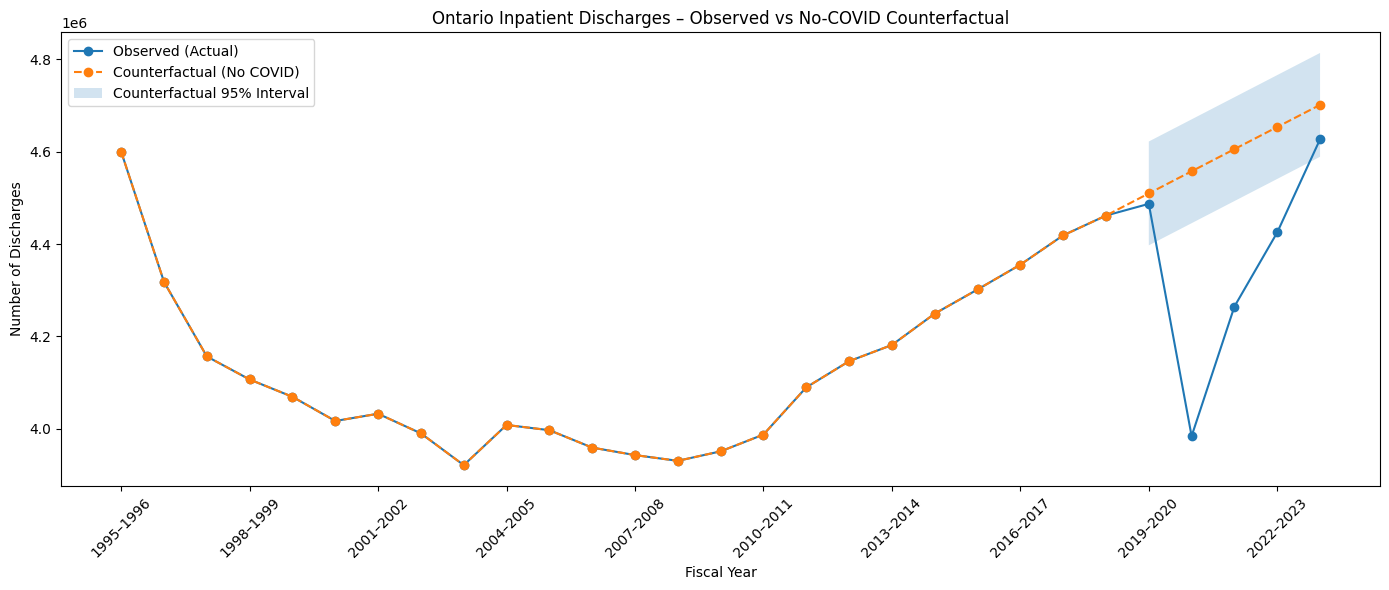

In [33]:
plt.figure(figsize=(14,6))

plt.plot(
    ontario_yearly["Year_Index"],
    ontario_yearly["Number_of_Discharges"],
    marker="o",
    label="Observed (Actual)"
)

plt.plot(
    counterfactual_series["Year_Index"],
    counterfactual_series["Number_of_Discharges"],
    linestyle="--",
    marker="o",
    label="Counterfactual (No COVID)"
)

plt.fill_between(
    counterfactual_df["Year_Index"],
    counterfactual_df["Lower_Bound"],
    counterfactual_df["Upper_Bound"],
    alpha=0.2,
    label="Counterfactual 95% Interval"
)

plt.xticks(
    ontario_yearly["Year_Index"][::3],
    ontario_yearly["Fiscal_Year"][::3],
    rotation=45
)

plt.title("Ontario Inpatient Discharges – Observed vs No-COVID Counterfactual")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Discharges")
plt.legend()
plt.tight_layout()
plt.show()


This figure compares observed inpatient discharges in Ontario with a counterfactual scenario that removes the effects of COVID-19. Up to 2018–2019, both series follow the same trajectory, indicating stable long-term growth in inpatient demand. From 2019 onward, the observed series drops sharply, reflecting the disruption caused by pandemic restrictions, deferred procedures, and capacity constraints.

The counterfactual line shows how discharges would have been expected to evolve if pre-pandemic trends had continued without interruption. The widening gap between the two lines during 2020–2023 highlights the scale of unmet inpatient activity during the COVID and recovery period. Although observed discharges begin to recover after 2021, they remain below the counterfactual baseline, suggesting that lost activity was not fully recaptured.

The shaded band represents the uncertainty around the counterfactual estimate, based on variation in pre-COVID data. Even within this uncertainty range, observed discharges remain consistently lower than expected, reinforcing the conclusion that the pandemic caused a sustained deviation from normal inpatient demand rather than a temporary fluctuation.


### Policy relevance

This analysis shows that COVID-19 caused a multi-year disruption to inpatient care delivery in Ontario, with discharge volumes remaining below expected levels even during the recovery period. The results suggest that deferred care was not fully recaptured and that underlying demand pressures persist. For healthcare planners, this highlights the importance of aligning inpatient capacity, workforce planning, and funding with long-term demand rather than short-term recovery signals.
